In [5]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

CODE = "/local/home/aarslan/mq"

annotation_json_file_path = f"{CODE}/scripts/08_reproduce_mq_experiments/data/ego4d/ego4d_clip_annotations_v3.json"

with open(annotation_json_file_path, "r") as annotation_json_file:
    annotation_dict = json.load(annotation_json_file)

annotations_data = []

for clip_id, clip_info in annotation_dict.items():
    video_id = clip_info["video_id"]
    clip_duration = clip_info["duration"]
    fps = clip_info["fps"]
    subset = clip_info["subset"]
    if subset in ["train", "val"]:
        for annotation in clip_info["annotations"]:
            annotations_data.append((subset, annotation["label"], video_id, clip_id, clip_duration, fps, annotation["segment"][1] - annotation["segment"][0], annotation["segment"][0], annotation["segment"][1]))
    else:
        annotations_data.append((subset, np.NaN, video_id, clip_id, clip_duration, fps, np.NaN))

annotations_df = pd.DataFrame(data=annotations_data, columns=["subset", "label", "video_id", "clip_id", "clip_duration", "fps", "label_duration", "label_start", "label_end"])


# FPS Histogram

Text(0, 0.5, 'Number of clips')

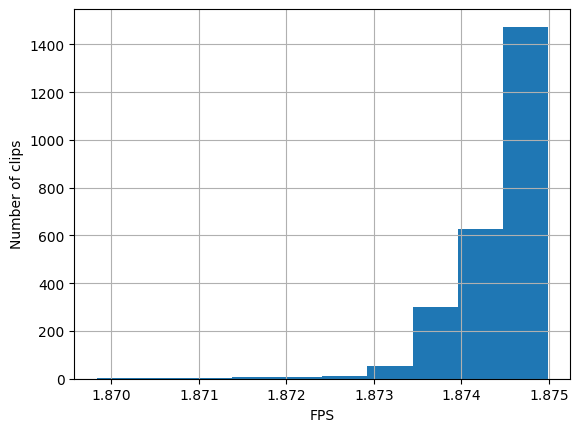

In [6]:
annotations_df.drop_duplicates(subset=["clip_id"])["fps"].hist(bins=10)
plt.xlabel("FPS")
plt.ylabel("Number of clips")


# Number of Clips per Subset Histogram

Text(0, 0.5, 'Number of clips')

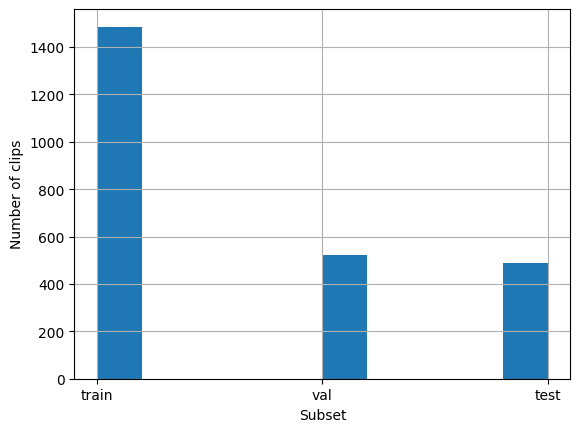

In [7]:
annotations_df.drop_duplicates(subset=["clip_id"])["subset"].hist()
plt.xlabel("Subset")
plt.ylabel("Number of clips")


# Number of Annotations per Clip Histogram

Text(0, 0.5, 'Number of clips with this many annotations')

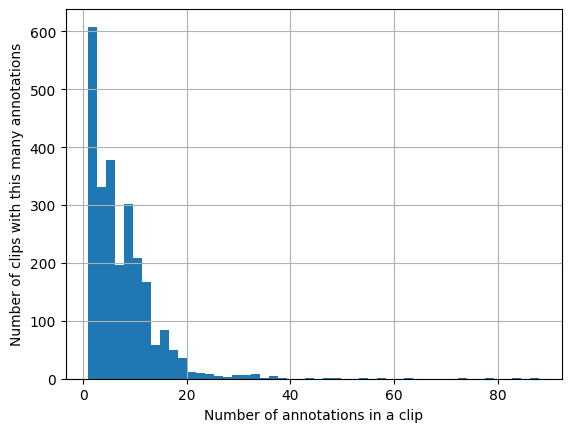

In [8]:
annotations_df.groupby("clip_id").count()["subset"].hist(bins=50)
plt.xlabel("Number of annotations in a clip")
plt.ylabel("Number of clips with this many annotations")

# Number of Clips per Video Histogram

Text(0, 0.5, 'Number of videos with this many clips')

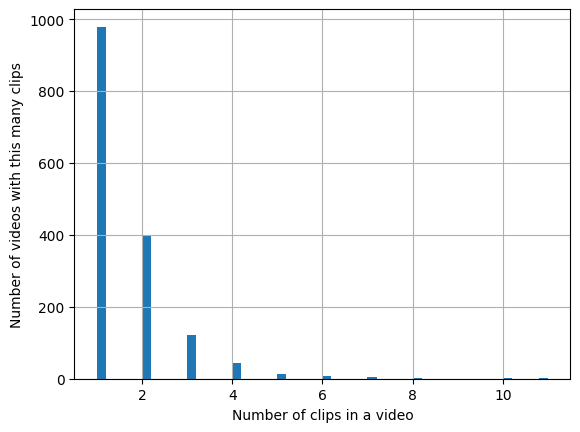

In [9]:
annotations_df.groupby(["video_id"]).agg({"clip_id": "nunique"})["clip_id"].hist(bins=50)
plt.xlabel("Number of clips in a video")
plt.ylabel("Number of videos with this many clips")


# Clip Duration Histogram

In [12]:
annotations_df.drop_duplicates(subset=["clip_id"])["clip_duration"].max()

480.03333333333353

Text(0, 0.5, 'Number of clips')

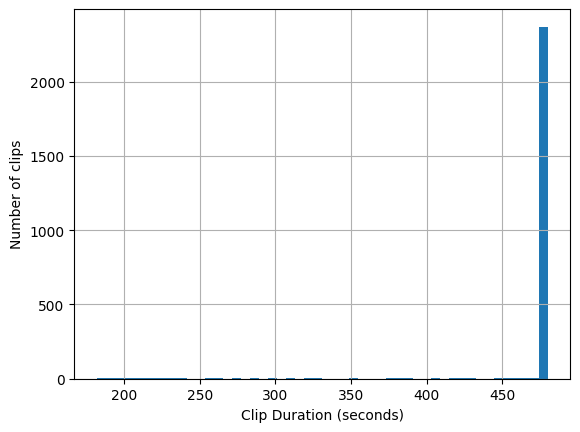

In [10]:
annotations_df.drop_duplicates(subset=["clip_id"])["clip_duration"].hist(bins=50)
plt.xlabel("Clip Duration (seconds)")
plt.ylabel("Number of clips")


# Annotation Duration Histogram

Text(0, 0.5, 'Number of annotations')

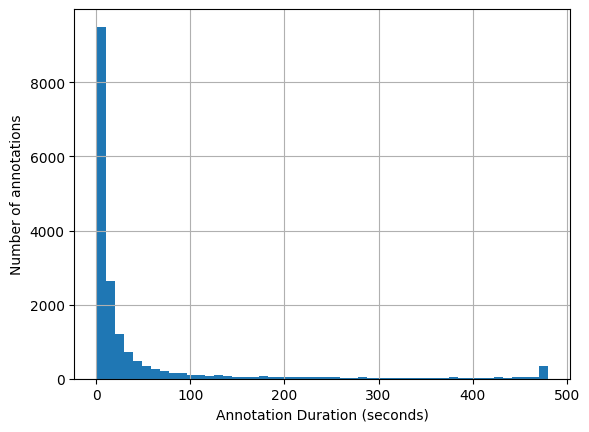

In [58]:
annotations_df["label_duration"].hist(bins=50)

plt.xlabel("Annotation Duration (seconds)")
plt.ylabel("Number of annotations")


# Label Counts

In [59]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(annotations_df.groupby("label").agg({"subset": "count"}).rename(columns={"subset": "count"}))


,count
label,
"""clean_/_repair_small_equipment_(mower,_trimmer_etc.)""",50
"""cut_/_chop_/_slice_a_vegetable,_fruit,_or_meat""",312
"""level_ground_/_soil_(eg._using_rake,_shovel,_etc)""",65
"""make_the_bed_/_arrange_pillows,_sheets_etc._on_bed""",55
"""put_on_safety_equipment_(e.g._gloves,_helmet,_safety_goggles)""",141
"""try-out_/_wear_accessories_(e.g._tie,_belt,_scarf)""",63
"""try-out_/_wear_clothing_items_(e.g._shirt,_jeans,_sweater)""",128
arrange_/_organize_clothes_in_closet/dresser,65
arrange_/_organize_items_in_fridge,51


# Label - (verb, noun) mapping

In [60]:
label_verb_noun_mapping = {
    '"clean_/_repair_small_equipment_(mower,_trimmer_etc.)"': [("clean", "small item"), ("clean", "small equipment"), ("clean", "mower"), ("clean", "trimmer"), ("repair", "small item"), ("repair", "small equipment"), ("repair", "trimmer"), ("repair", "mower")],
    '"cut_/_chop_/_slice_a_vegetable,_fruit,_or_meat"': [("cut", "vegetable"), ("cut", "fruit"), ("cut", "meat"), ("chop", "vegetable"), ("chop", "fruit"), ("chop", "meat"), ("slice", "vegetable"), ("slice", "fruit"), ("slice", "meat")],
    '"level_ground_/_soil_(eg._using_rake,_shovel,_etc)"': [("level", "ground"), ("level", "soil"), ("level", "surface"), ("use", "rake"), ("use", "shovel"), ("shovel", "ground"), ("shovel", "soil"), ("shovel", "surface"), ("rake", "ground"), ("rake", "soil"), ("rake", "surface")],
    '"make_the_bed_/_arrange_pillows,_sheets_etc._on_bed"': [("make", "bed"), ("arrange", "bed"), ("tidy", "bed"), ("arrange", "pillow"), ("tidy", "pillow"), ("tidy", "sheet")],
    '"put_on_safety_equipment_(e.g._gloves,_helmet,_safety_goggles)"': [("wear", "glove"), ("put on", "glove"), ("wear", "safety equipment"), ("put on", "safety equipment"), ("wear", "helmet"), ("put on", "helmet"), ("wear", "safety goggles"), ("put on", "safety goggles")],
    '"try-out_/_wear_accessories_(e.g._tie,_belt,_scarf)"': [("wear", "accessory"), ("wear", "tie"), ("wear", "belt"), ("wear", "scarf"), ("wear", "scarf"), ("wear", "belt"), ("wear", "tie")],
    '"try-out_/_wear_clothing_items_(e.g._shirt,_jeans,_sweater)"': [("wear", "shirt"), ("wear", "cloth"), ("wear", "jeans"), ("wear", "sweater")],
    'arrange_/_organize_clothes_in_closet/dresser': [("arrange", "cloth"), ("arrange", "closet"), ("arrange", "dresser"), ("tidy", "cloth"), ("tidy", "closet"), ("tidy", "dresser"), ("organize", "cloth"), ("organize", "dresser"), ("organize", "closet")],
    'arrange_/_organize_items_in_fridge': [("arrange", "fridge"), ("organize", "fridge")],
    'arrange_/_organize_other_items': [("arrange", "item"), ("organize", "item")],
    'arrange_pillows_on_couch_/_chair': [("arrange", "couch"), ("tidy", "couch"), ("arrange", "chair"), ("tidy", "chair")],
    'browse_through_accessories_on_rack_/_shelf': [("browse through", "accessory"), ("browse over", "accessory"), ("look over", "accessory")],
    'browse_through_clothing_items_on_rack_/_shelf_/_hanger': [("browse through", "cloth"), ("browse over", "cloth"), ("look over", "cloth"), ("browse through", "clothing item"), ("browse over", "clothing item"), ("look over", "clothing item")],
    'browse_through_groceries_or_food_items_on_rack_/_shelf': [("browse through", "grocery"), ("browse over", "grocery"), ("look over", "grocery"), ("browse through", "food"), ("browse over", "food"), ("look over", "food")],
    'browse_through_other_items_on_rack_/_shelf': [("browse through", "item"), ("browse over", "item"), ("look over", "item")],
    'chop_/_cut_wood_pieces_using_tool': [("axe", "wood"), ("chop", "wood"), ("cut", "wood"), ("use", "axe"), ("use", "saw"), ("saw", "wood")],
    'clean_/_sweep_floor_with_broom': [("broom", "ground"), ("broom", "surface"), ("broom", "floor"), ("use", "broom"), ("sweep", "ground"), ("sweep", "surface"), ("sweep", "floor"), ("clean", "ground"), ("clean", "surface"), ("clean", "floor")],
    'clean_/_wipe_/_oil_metallic_item': [("clean", "metal"), ("wipe", "metal"), ("clean", "metallic item"), ("wipe", "metallic item"), ("oil", "metal"), ("oil", "metallic item")],
    'clean_/_wipe_a_table_or_kitchen_counter': [("clean", "table"), ("clean", "counter"), ("clean", "kitchen counter"), ("wipe", "table"), ("wipe", "counter"), ("wipe", "kitchen counter")],
    'clean_/_wipe_kitchen_appliance': [("clean", "applicance"), ("clean", "kitchen appliance"), ("wipe", "appliance"), ("wipe", "kitchen appliance")],
    'clean_/_wipe_other_surface_or_object': [("clean", "surface"), ("clean", "object"), ("wipe", "surface"), ("wipe", "object")],
    'climb_up_/_down_a_ladder': [("climb", "ladder"), ("climb up", "ladder"), ("climb down", "ladder")],
    'collect_/_rake_dry_leaves_on_ground': [("collect", "leave"), ("rake", "leave"), ("pick", "leave"), ("rake", "ground")],
    'compare_two_clothing_items': [("compare", "cloth"), ("compare", "clothing item")],
    'converse_/_interact_with_someone': [("interact", "someone"), ("talk", "someone"), ("interact", "person"), ("talk", "person"), ("converse", "someone"), ("converse", "person")],
    'count_money_before_paying': [("count", "money"), ("count", "cash")],
    'cut_/_trim_grass_with_a_lawnmower': [("use", "lawnmower")],
    'cut_/_trim_grass_with_other_tools': [("cut", "grass"), ("trim", "grass")],
    'cut_dough': [("cut", "dough"), ("slice", "dough")],
    'cut_open_a_package_(e.g._with_scissors)': [("cut", "package"), ("slice", "package")],
    'cut_other_item_using_tool': [("cut", "item"), ("slice", "item")],
    'cut_thread_/_paper_/_cardboard_using_scissors_/_knife_/_cutter': [("cut", "thread"), ("cut", "paper"), ("cut", "cardboard"), ("slice", "thread"), ("slice", "paper"), ("slice", "cardboard")],
    'cut_tree_branch': [("cut", "branch"), ("cut", "tree"), ("cut", "tree branch")],
    'dig_or_till_the_soil_by_hand': [("dig", "soil"), ("till", "soil")],
    'dig_or_till_the_soil_with_a_hoe_or_other_tool': [("hoe", "soil")],
    'dismantle_other_item': [("dismantle", "item")],
    'do_some_exercise': [("do", "exercise")],
    'drill_into_wall_/_wood_/_floor_/_metal': [("drill", "wall"), ("drill", "wood"), ("drill", "floor"), ("drill", "metal")],
    'drink_beverage': [("drink", "beverage")],
    'drive_a_vehicle': [("drive", "vehicle")],
    'eat_a_snack': [("eat", "snack")],
    'enter_a_supermarket_/_shop': [("enter", "supermarket"), ("enter", "shop")],
    'exit_a_supermarket_/_shop': [("exit", "supermarket"), ("exit", "shop")],
    'fill_a_pot_/_bottle_/_container_with_water': [("fill", "pot"), ("fill", "bottle"), ("fill", "container")],
    'fix_/_remove_/_replace_a_tire_or_wheel': [("fix", "tire"), ("remove", "tire"), ("replace", "tire"), ("fix", "wheel"), ("remove", "wheel"), ("replace", "wheel")],
    'fix_bonnet_/_engine_of_car': [("fix", "bonnet"), ("fix", "engine"), ("repair", "bonnet"), ("repair", "engine")],
    'fix_other_item': [("fix", "item")],
    'fix_pipe_/_plumbing': [("fix", "pipe"), ("fix", "plumbing"), ("repair", "pipe"), ("repair", "plumbing")],
    'fix_wiring': [("fix", "wiring"), ("repair", "wiring")],
    'fold_clothes_/_sheets': [("fold", "cloth"), ("fold", "sheet")],
    'fry_dough': [("fry", "dough")],
    'fry_other_food_item': [("fry", "food")],
    'hang_clothes_in_closet_/_on_hangers': [("hang", "cloth"), ("hang", "closet")],
    'hang_clothes_to_dry': [("hang", "cloth")],
    'harvest_vegetables_/_fruits_/_crops_from_plants_on_the_ground': [("harvest", "vegetable"), ("harvest", "fruit"), ("harvest", "crop"), ("harvest", "plant")],
    'interact_or_play_with_pet_/_animal': [("interact", "pet"), ("interact", "animal"), ("play", "pet"), ("play", "animal")],
    'iron_clothes_or_sheets': [("iron", "cloth"), ("iron", "sheet")],
    'knead_/_shape_/_roll-out_dough': [("knead", "dough"), ("shape", "dough"), ("roll out", "dough")],
    'load_/_unload_a_washing_machine_or_dryer': [("load", "washing machine"), ("unload", "washing machine"), ("load", "dryer"), ("unload", "dryer")],
    'look_at_clothes_in_the_mirror': [("look", "cloth"), ("look", "mirror")],
    'make_coffee_or_tea_/_use_a_coffee_machine': [("make", "coffee"), ("make", "tea"), ("use", "coffee machine")],
    'mark_item_with_pencil_/_pen_/_marker': [("mark", "item")],
    'measure_wooden_item_using_tape_/_ruler': [("use", "ruler"), ("use", "tape"), ("measure", "wooden")],
    'move_/_shift_/_arrange_small_tools': [("move", "small tool"), ("shift", "small tool"), ("arrange", "small tool")],
    'move_/_shift_around_construction_material': [("move", "construction material"), ("shift around", "construction material")],
    'pack_food_items_/_groceries_into_bags_/_boxes': [("pack", "food"), ("pack", "grocery"), ("box", "food"), ("box", "grocery")],
    'pack_other_items_into_bags_/_boxes': [("pack", "item"), ("box", "item")],
    'pack_soil_into_the_ground_or_a_pot_/_container': [("pack", "soil"), ("ground", "soil")],
    'paint_using_paint_brush_/_roller': [("use", "brush"), ("use", "roller"), ("paint", "painting")],
    'pay_at_billing_counter': [("pay", "bill"), ("use", "counter")],
    'peel_a_fruit_or_vegetable': [("peel", "fruit"), ("peel", "vegetable")],
    'place_items_in_shopping_cart': [("place", "item"), ("use", "shopping cart"), ("fill", "shopping cart"), ("place", "shopping cart")],
    'plant_seeds_/_plants_/_flowers_into_ground': [("plant", "seed"), ("plant", "plant"), ("plant", "flower")],
    'plaster_wall_/_surface': [("plaster", "wall"), ("plaster", "surface")],
    'play_a_video_game': [("play", "game"), ("play", "video game")],
    'play_board_game_or_card_game': [("play", "board game"), ("play", "card game")],
    'prepare_or_apply_cement_/_concrete_/_mortar': [("prepare", "cement"), ("apply", "cement"), ("prepare", "concrete"), ("apply", "concrete"), ("prepare", "mortar"), ("apply", "mortar")],
    'put_away_(or_take_out)_dishes_/_utensils_in_storage': [("put away", "dish"), ("put away", "utensil"), ("take out", "dish"), ("take out", "utensil")],
    'put_away_(or_take_out)_food_items_in_the_fridge': [("put away", "food"), ("take out", "food")],
    'put_away_(or_take_out)_ingredients_in_storage': [("put away", "ingredient"), ("take out", "ingredient")],
    'put_food_into_the_oven_to_bake': [("bake", "food"), ("use", "oven")],
    'read_a_book_/_magazine_/_shopping_list_etc.': [("read", "book"), ("read", "magazine"), ("read", "shopping list")],
    'remove_food_from_the_oven': [("empty", "oven")],
    'remove_weeds_from_ground': [("remove", "weed"), ("pick", "weed"), ("collect", "weed")],
    'rinse_/_drain_other_food_item_in_sieve_/_colander': [("rinse", "food"), ("drain", "food"), ("use", "sieve"), ("use", "colander")],
    'serve_food_onto_a_plate': [("use", "plate"), ("place", "food"), ("serve", "food")],
    'smoke_cigar_/_cigarette_/_vape': [("smoke", "cigar"), ("smoke", "cigarette"), ("smoke", "vape")],
    'smooth_wood_using_sandpaper_/_sander_/_tool': [("use", "sandpaper"), ("use", "sander"), ("use", "tool"), ("smooth", "wood")],
    'stand_in_the_queue_/_line_at_a_shop_/_supermarket': [("stand", "queue"), ("stand", "line"), ("stand", "shop"), ("stand", "supermarket")],
    'stir_/_mix_food_while_cooking': [("stir", "food"), ("mix", "food")],
    'stir_/_mix_ingredients_in_a_bowl_or_pan_(before_cooking)': [("stir", "ingredients"), ("mix", "ingredients")],
    'take_photo_/_record_video_with_a_camera': [("take", "photo"), ("record", "video"), ("take", "video")],
    'taste_food_while_cooking': [("taste", "food"), ("eat", "food")],
    'throw_away_trash_/_put_trash_in_trash_can': [("throw away", "trash"), ("throw", "trash"), ("fill", "thash can")],
    'tie_up_branches_/_plants_with_string': [("tie", "branch"), ("tie", "plant")],
    'trim_hedges_or_branches': [("trim", "hedge"), ("trim", "branch")],
    'turn-on_/_light_the_stove_burner': [("turn on", "stove burner"), ("light", "stove burner"), ("use", "stove burner")],
    'use_a_laptop_/_computer': [("use", "laptop"), ("use", "computer")],
    'use_a_vacuum_cleaner_to_clean': [("use", "vacuum cleaner"), ("vacuum", "dirt")],
    'use_hammer_/_nail-gun_to_fix_nail': [("use", "hammer"), ("use", "nail gun"), ("fix", "nail")],
    'use_phone': [("use", "phone")],
    'walk_down_stairs_/_walk_up_stairs': [("walk", "stair"), ("walk down", "stair"), ("walk up", "stair")],
    'wash_dishes_/_utensils_/_bakeware_etc.': [("wash", "dish"), ("wash", "utensil"), ("wash", "bakeware")],
    'wash_hands': [("wash", "hand")],
    'wash_vegetable_/_fruit_/_food_item': [("wash", "vegetable"), ("wash", "fruit"), ("wash", "food")],
    'watch_television': [("watch", "movie"), ("watch", "program"), ("watch", "show"), ("watch", "television")],
    'water_soil_/_plants_/_crops': [("water soil", "water plant", "water crop")],
    'weigh_food_/_ingredient_using_a_weighing_scale': [("weigh", "food"), ("weigh", "ingredient")],
    'withdraw_money_from_atm_/_operate_atm': [("withdraw", "money"), ("withdraw", "cash"), ("withdraw", "atm"), ("operate", "atm")],
    'write_notes_in_a_paper_/_book': [("write", "note"), ("write", "paper"), ("write", "book"), ("write", "notebook")],
}

# Annotation tIoU Histogram

For each annotation, we check the tIoU with other annotations in the same clip. We exclude tIoUs with non-intersecting annotations.

Text(0, 0.5, 'Number of annotations with this tIoU')

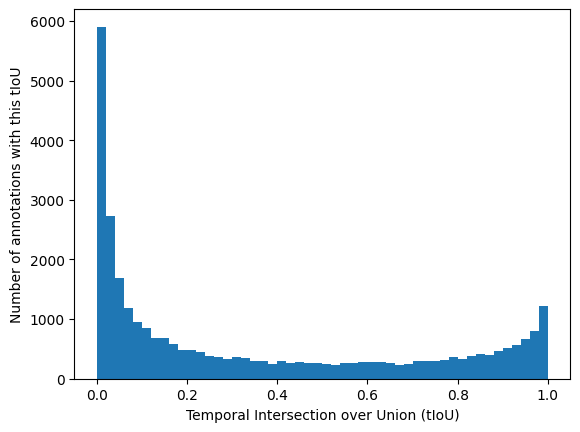

In [79]:
train_val_annotations_df = annotations_df[annotations_df["subset"].apply(lambda x: x in ["train", "val"])]

clip_id_intersection_mapping = {}

tIoUs = []
for current_index, current_row in train_val_annotations_df.iterrows():
    current_clip_id = current_row["clip_id"]
    clip_id_intersection_mapping[current_clip_id] = 0
    current_label_start = current_row["label_start"]
    current_label_end = current_row["label_end"]
    other_rows_with_same_clip_id = train_val_annotations_df[train_val_annotations_df["clip_id"] == current_clip_id]
    for other_index, other_row in other_rows_with_same_clip_id.iterrows():
        if current_index == other_index:
            continue
        other_label_start = other_row["label_start"]
        other_label_end = other_row["label_end"]
        if current_label_start >= other_label_end or other_label_start >= current_label_end: # there is no intersection
            continue
        else:
            clip_id_intersection_mapping[current_clip_id] += 1
            maximum_start = np.maximum(current_label_start, other_label_start)
            minimum_end = np.minimum(current_label_end, other_label_end)
            intersection = minimum_end - maximum_start

            maximum_end = np.maximum(current_label_end, other_label_end)
            minimum_start = np.minimum(current_label_start, other_label_start)
            union = maximum_end - minimum_start

            tIoUs.append(intersection / float(union))
        
            clip_id_intersection_mapping[current_clip_id] += 1

plt.hist(tIoUs, bins=50)
plt.xlabel("Temporal Intersection over Union (tIoU)")
plt.ylabel("Number of annotations with this tIoU")



# Annotation Number of Intersections Histogram

Text(0, 0.5, 'Number of annotations with this many intersections')

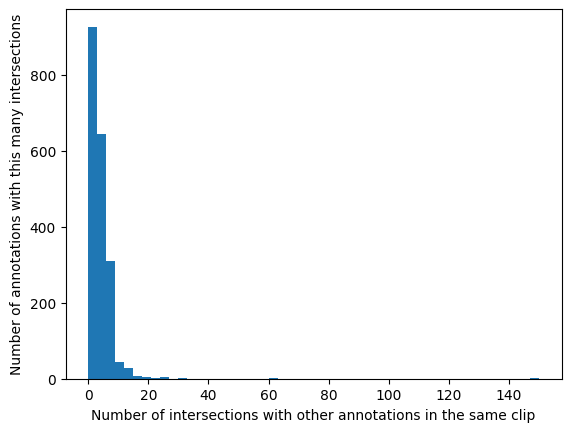

In [78]:
plt.hist(list(clip_id_intersection_mapping.values()), bins=50)
plt.xlabel("Number of intersections with other annotations in the same clip")
plt.ylabel("Number of annotations with this many intersections")